In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns

# The Checklist
- [ ] Get the data
- [ ] Do the One Class SVM, Isolation Tree, and Local Outlier Factor
- [ ] Clip the Target
- [ ] Arithmetic Mean


In [3]:
df = pd.read_csv('sample_submission.csv')
df

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,...,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,9.10,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,...,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,8.21,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,...,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.39,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,...,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.07,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,...,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,8.08,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,...,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,3496,8.09,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,...,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,3497,9.95,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,...,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,3498,9.52,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,...,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


# Setting up the Helper Methods

Now I am going to setup a streamlined k folds and random forest regressor

In [4]:
def test_on_data(x_train, x_test, y_train, y_test):
    rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

    rf.fit(x_train, y_train)
    preds = rf.predict(x_test)
    return mean_squared_error(y_test, preds)

In [5]:
def test_on_data_cv(x, y, cv=5):
    rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

    scores = cross_val_score(rf, x, y, cv=cv, scoring='neg_root_mean_squared_error')
    scores
    return scores

TODO: add custom K-Folds

In [31]:
def test_with_std(x, y, cv=5, n=10):
    score_total = []
    for i in range(n):
        score_total.append(test_on_data_cv(x, y, cv=cv))
    score_total = np.array(score_total)
    print(f'Mean {score_total.mean()} and std {score_total.std()}')

In [32]:
# Let's try these methods.
test_with_std(df.drop('target', axis=1), df.target)

Mean -1.3997980435425417 and std 0.6068702815749446


For normal k-folds without any change in data, we got a pretty bad score and even worst we got a big std compared to mean. For curisoty sake I'm going to do it on the clipped version too.

In [35]:
test_with_std(df.drop('target', axis=1), df['target'].clip(7, 16))

Mean -0.946609947720496 and std 0.02630068246343222


Ok this seems better with 0.9 MSE and 0.02 std, MAYBE I SHOULD VALUE STD MORE.

In [45]:
def give_zero_sub(df=df):
    dfc = df.copy()
    dfc.iloc[:]=0
    return dfc

# Half hearted EDA & Outlier Detection

In [61]:
data_to_plot = df.drop(['id'], axis=1)

# Determine the number of columns to plot, 36
num_cols = len(data_to_plot.columns)

# Calculate the number of rows and columns for the subplots
num_rows = (num_cols + 2) // 3
num_cols_per_subplot = min(num_cols, 5)

print(f'Cols {num_cols} \
      num_rows {num_rows} \
      num_cols_per_subplot {num_cols_per_subplot}')

Cols 36       num_rows 12       num_cols_per_subplot 5


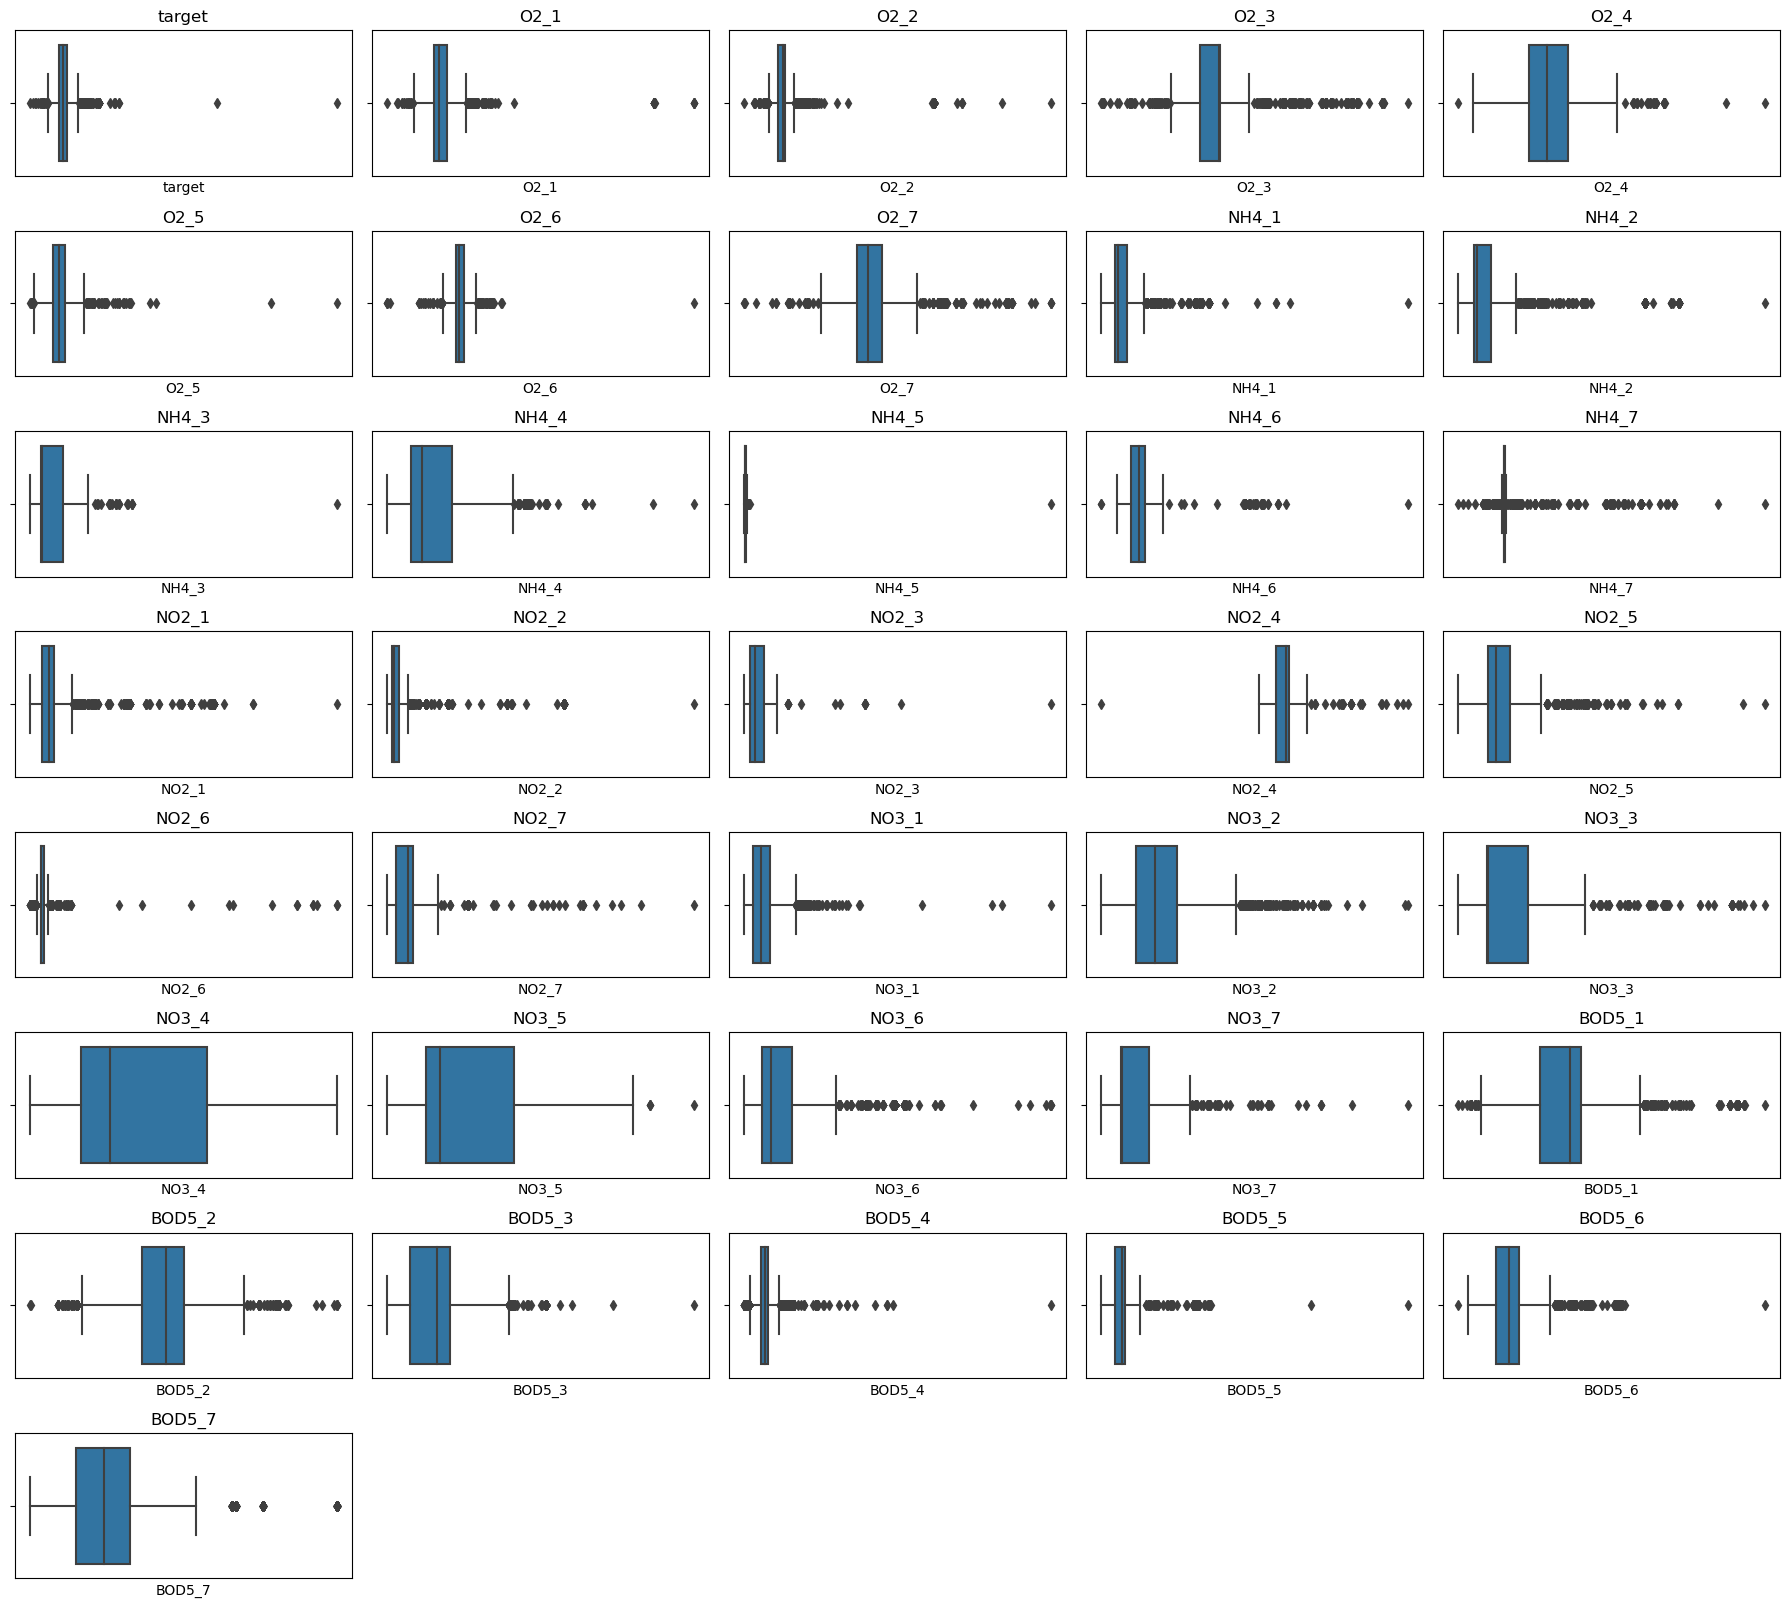

In [64]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols_per_subplot, figsize=(18, 2 * num_rows))

# Flatten the axes for iteration
axes = axes.flatten()

# Create box plots for each column
for i, col in enumerate(data_to_plot.columns):
    # The main magic happens here:
    sns.boxplot(x=data_to_plot[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xticks([])  # Remove x-axis labels for better readability
    
# Remove any empty subplots
for i in range(num_cols, num_rows * num_cols_per_subplot):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Axes: xlabel='id', ylabel='target'>

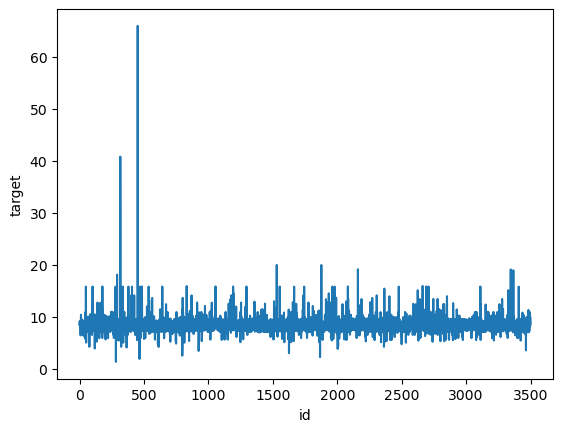

In [53]:
sns.lineplot(data=df, x='id',y='target')

In [54]:
df[df.target>20]

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
316,316,40.78,40.90,40.90,9.500,6.805,5.01,8.76,6.805,0.49,...,9.805,4.53,4.42,4.8,3.500,4.650,6.025,5.070,3.850,4.14
451,451,65.93,40.95,65.95,9.265,6.625,5.01,8.37,6.375,0.71,...,7.795,1.73,1.78,4.1,4.645,4.725,5.725,10.645,3.025,3.80


2 outliers on target which are 316 and 451, from this point we are going to pretend that ID column does not exist, because internet says so.

# Outlier Cleaning

## SVM

In [80]:
svm = SGDOneClassSVM(0.3)
svm.fit(df.drop('id', axis=1))
svm_pred = svm.predict(df.drop('id', axis=1))
svm_remove_idx = np.where(svm_pred==-1)[0]

SGDOneClassSVM works best without id for finding outliers.

In [81]:
svm_remove_idx

array([ 282,  463,  510,  613,  797, 1054, 1502, 2006, 2533, 2535, 3464])

In [82]:
isofor = IsolationForest(contamination=0.005)
isofor.fit(df.drop('id',axis=1))
iso_pred = isofor.predict(df.drop('id',axis=1))
iso_remove_idx = np.where(iso_pred==-1)[0]
len(iso_remove_idx)

/Users/ameerramzani/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


18

In [89]:
lof = LocalOutlierFactor(contamination=0.005)
lof_pred = lof.fit_predict(df.drop('id',axis=1))
lof_remove_idx = np.where(lof_pred==-1)[0]
len(lof_remove_idx)

18

In [96]:
np.union1d(np.union1d(lof_remove_idx, iso_remove_idx), svm_remove_idx)

array([  46,  282,  304,  320,  451,  457,  463,  510,  564,  596,  613,
        694,  712,  797,  831,  867,  939,  971, 1054, 1064, 1074, 1145,
       1146, 1152, 1177, 1473, 1502, 1826, 1952, 1989, 2006, 2233, 2311,
       2436, 2513, 2533, 2535, 2558, 2588, 2662, 2856, 2860, 3166, 3393,
       3402, 3464])